In [1]:
!pip install rdkit
!pip install scikit-learn
!pip install lightgbm
!pip install xgboost
!pip install joblib

In [1]:
#pip install pandas numpy scikit-learn scipy matplotlib
!pip install matplotlib
!pip install numpy
!pip install pandas

In [2]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Descriptors, rdMolDescriptors
from rdkit.Chem import AllChem
from rdkit import DataStructs
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation
from xgboost import XGBRegressor
import joblib
from rdkit.Chem import Descriptors
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_squared_error

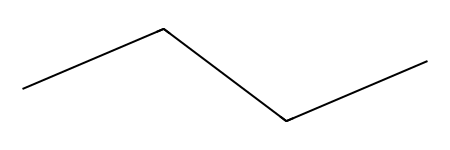

In [3]:
mol = Chem.MolFromSmiles('CCCC')
mol

    ID                                             Smiles MolWeight  \
0    1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O   1606.29   
1    2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...   1527.47   
2    3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O   1466.35   
3    4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O   1762.46   
4    5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2   250.323   
5    6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    1570.5   
6    7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...      1846   
7    8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    418.44   
8    9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O  1371.25    
9   10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    1840.6   
10  11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...   1553.55   
11  12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC   1503.36   
12  13      COc1ccc2c(c1)n(c(c2C(=O)O)C(=O)c1ccc(cc1)Cl)C    1492.8   
13  14

Here is an improved version of this model
=
=
=
=
=
=
=
=
=-
-


In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file.
    Assumes columns C->Q (indices 2:17) are features (X),
    and column R (index 17) is 'Enhancement Factor' (y).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head(len(df)))  # For small data, we can show the entire set

    feature_cols = df.columns[2:17]  # 15 features
    target_col = df.columns[17]      # Enhancement Factor
    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

def remove_correlated_features(X, feature_cols, threshold=0.90):
    """
    Optional step to remove features that have absolute Spearman correlation
    above 'threshold'. Returns pruned X and updated feature_cols.
    """
    # Create a DataFrame to compute correlation
    df_features = pd.DataFrame(X, columns=feature_cols)
    corr_matrix = df_features.corr(method='spearman').abs()

    # Identify columns to drop
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

    # Drop correlated columns
    df_pruned = df_features.drop(columns=to_drop)
    print(f"\nRemoved {len(to_drop)} highly correlated features (threshold={threshold}).")
    print("Dropped features:", to_drop)
    return df_pruned.values, df_pruned.columns

def evaluate_model(model, X, y, description="All Data"):
    """
    Prints MSE, RMSE, MAE, R² for the model on (X, y).
    """
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)

    print(f"\nEvaluation on {description}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

def main():
    # 1. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)# Replace with your CSV path
    X_raw, y, feature_cols = load_dataset(file_path)

    # 2. (Optional) Remove highly correlated features
    X_pruned, pruned_cols = remove_correlated_features(X_raw, feature_cols, threshold=0.90)

    # 3. Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pruned)

    # 4. Define param distributions for RandomizedSearchCV
    #    We'll tune critical hyperparameters of RandomForest
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(2, 10),
        'min_samples_leaf': randint(1, 4),
        'max_features': uniform(0.5, 0.5)  # random fraction of features used
    }

    # 5. K-fold cross-validation (k=5). For 16 samples, you can also try LeaveOneOut()
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 6. Initialize base RandomForestRegressor
    rf_base = RandomForestRegressor(random_state=42)

    # 7. RandomizedSearchCV for hyperparameter tuning
    from sklearn.model_selection import RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_distributions,
        n_iter=30,              # number of random combinations
        scoring='r2',           # aim to maximize R²
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

    # 8. Fit the search on the entire dataset (X_scaled, y)
    random_search.fit(X_scaled, y)

    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")

    # 9. Retrieve best model (refitted on all data used in CV)
    best_model = random_search.best_estimator_

    # 10. Evaluate best model on entire dataset
    evaluate_model(best_model, X_scaled, y, description="All Data")

    # 11. Example: Predict Enhancement Factor for new data
    # (Suppose you have a new molecule's pruned feature vector in the same order)
    new_molecule_features = np.array([[
        1606.29, 0.41483, 0.07137, 0.3726,
        12.8, 1.29, 0.11, 0.23, 5.52, 0.33,
        0.1, 1, 0, 0, 1  # Original 15 features
    ]], dtype=float)

    # If some features were dropped, remove or reorder them accordingly:
    # e.g. if pruned_cols is fewer than 15, new_molecule_features must match that shape.

    # Transform the new data with the same scaler
    new_molecule_pruned = pd.DataFrame(new_molecule_features, columns=feature_cols)
    new_molecule_pruned = new_molecule_pruned.drop(
        columns=[col for col in feature_cols if col not in pruned_cols], errors='ignore'
    )
    new_molecule_scaled = scaler.transform(new_molecule_pruned.values)

    predicted_value = best_model.predict(new_molecule_scaled)
    print(f"\nPredicted Enhancement Factor for new molecule: {predicted_value[0]:.4f}")

if __name__ == "__main__":
    main()



Data Preview:
    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O


Best Hyperparameters found:
{'max_depth': 8, 'max_features': 0.8049983288913105, 'min_samples_leaf': 3, 'n_estimators': 84}
Best R² from CV: -699.6975

Evaluation on All Data:
  MSE:  16922276.9402
  RMSE: 4113.6695
  MAE:  1882.6697
  R²:   0.4340

Predicted Enhancement Factor for new molecule: 5364.3886


Now we do feature analysis for model
=
=
=
=
=
=
=
=
=
=
=


Data Preview:
    ID                                              Smiles  MolWeight  \
0     1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1     2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2     3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3     4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4     5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   
5     6  CC(C)C[C@H](C(=O)NCc1ccc(cc1)c1ccccc1C(=N)N=N)...    451.527   
6     7  CCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])C)...    374.393   
7     8  COCCOC(=O)C1=C(C)NC(=C(C1c1ccccc1[N+](=O)[O-])...    434.445   
8     9                       O=C1Nc2ccccc2C2=CC=CC=C2C1=O    223.231   
9    10  CC1=NC(C)=NC(OCC2CCC(OC3=NC(N4CCN(C)CC4)=NC(C4...    559.502   
10   11  CC(C)CC(CC=C)C(=O)OC[C@@H]1CC[C@@H](CC1)C(=O)O...    338.488   
11   12      COc1ccc(cc1)/C=C/C(=O)CC(=O)/C=C/c1ccc(cc1)OC    336.387   
12   13      COc1ccc2c(c1)n(c(c2C(=O

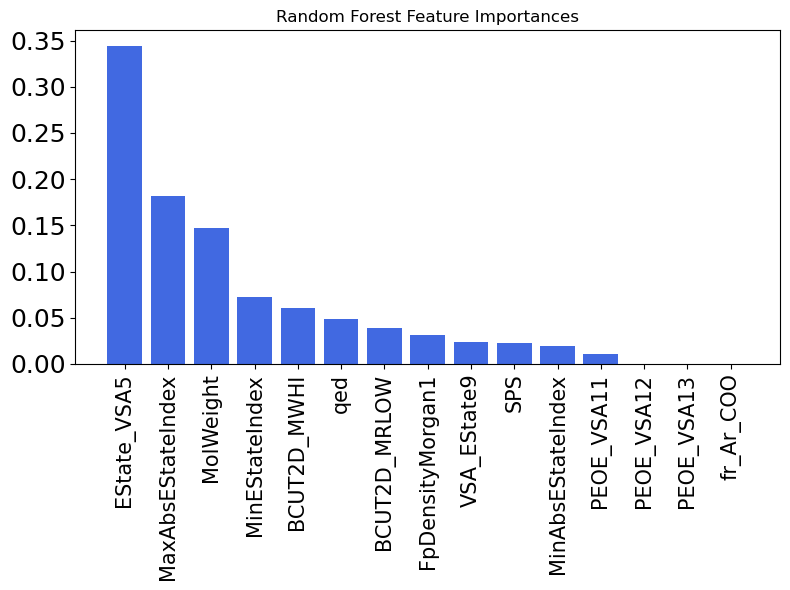


Predicted Enhancement Factor for new molecule: 5364.3886


In [3]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file.
    Assumes columns C->Q (indices 2:17) are features (X),
    and column R (index 17) is 'Enhancement Factor' (y).
    """
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head(len(df)))  # For small data, we can show the entire set

    feature_cols = df.columns[2:17]  # 15 features
    target_col = df.columns[17]      # Enhancement Factor
    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

def remove_correlated_features(X, feature_cols, threshold=0.90):
    """
    Optional step to remove features that have absolute Spearman correlation
    above 'threshold'. Returns pruned X and updated feature_cols.
    """
    df_features = pd.DataFrame(X, columns=feature_cols)
    corr_matrix = df_features.corr(method='spearman').abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

    df_pruned = df_features.drop(columns=to_drop)
    print(f"\nRemoved {len(to_drop)} highly correlated features (threshold={threshold}).")
    print("Dropped features:", to_drop)
    return df_pruned.values, df_pruned.columns

def evaluate_model(model, X, y, description="All Data"):
    """
    Prints MSE, RMSE, MAE, R² for the model on (X, y).
    """
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)

    print(f"\nEvaluation on {description}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")

def plot_feature_importances(model, feature_cols, max_features=None):
    """
    Plots feature importances for the trained RandomForestRegressor.
    If max_features is specified, only the top N features are shown.
    """
    importances = model.feature_importances_
    # Pair each importance with its feature name
    feat_imp_pairs = list(zip(feature_cols, importances))
    # Sort descending by importance
    feat_imp_pairs.sort(key=lambda x: x[1], reverse=True)

    if max_features is not None:
        feat_imp_pairs = feat_imp_pairs[:max_features]

    labels, scores = zip(*feat_imp_pairs)

    plt.figure(figsize=(8, 6))
    plt.bar(range(len(scores)), scores, color="royalblue")
    plt.xticks(range(len(scores)), labels, rotation=90, fontsize=15)
    plt.yticks(fontsize=18)
    plt.title("Random Forest Feature Importances")
    plt.tight_layout()
    plt.show()

def main():
    # 1. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'
      # Replace with your CSV path
    X_raw, y, feature_cols = load_dataset(file_path)

    # 2. (Optional) Remove highly correlated features
    X_pruned, pruned_cols = remove_correlated_features(X_raw, feature_cols, threshold=0.90)

    # 3. Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_pruned)

    # 4. Define param distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(2, 10),
        'min_samples_leaf': randint(1, 4),
        'max_features': uniform(0.5, 0.5)
    }

    # 5. K-fold cross-validation
    from sklearn.model_selection import KFold
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 6. Initialize base RandomForestRegressor
    rf_base = RandomForestRegressor(random_state=42)

    # 7. RandomizedSearchCV for hyperparameter tuning
    from sklearn.model_selection import RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_distributions,
        n_iter=30,
        scoring='r2',
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

    # 8. Fit the search on the entire dataset
    random_search.fit(X_scaled, y)

    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")

    # 9. Retrieve best model
    best_model = random_search.best_estimator_

    # 10. Evaluate best model on entire dataset
    evaluate_model(best_model, X_scaled, y, description="All Data")

    # 11. Plot Feature Importances
    #     The pruned_cols list may have fewer columns than the original dataset
    plot_feature_importances(best_model, pruned_cols, max_features=len(pruned_cols))

    # 12. Example: Predict Enhancement Factor for new data
    new_molecule_features = np.array([[
        1606.29, 0.41483, 0.07137, 0.3726,
        12.8, 1.29, 0.11, 0.23, 5.52, 0.33,
        0.1, 1, 0, 0, 1
    ]], dtype=float)

    # If some features were dropped, remove them from new_molecule_features as well
    new_df = pd.DataFrame(new_molecule_features, columns=feature_cols)
    new_df = new_df.drop(columns=[col for col in feature_cols if col not in pruned_cols], errors='ignore')
    new_molecule_scaled = scaler.transform(new_df.values)

    predicted_value = best_model.predict(new_molecule_scaled)
    print(f"\nPredicted Enhancement Factor for new molecule: {predicted_value[0]:.4f}")

if __name__ == "__main__":
    main()



Here is ml for evaluation metrics for both training and test set:
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 -
                                 =
                                 =
                                 =
                                 =
                                 =
                                 =
                                 =
                                 


Data Preview:
   ID                                              Smiles  MolWeight  \
0    1                         CC(C)Cc1ccc(cc1)C(C)C(=O)O    206.285   
1    2  CC(C)C1C(=O)CC2C(C1O)(CC(C1=CC(=O)C=C2C1(C)O)F...    380.412   
2    3                    CN1NS(=O)(=O)C2=C(O)C=CN=C2C1=O    229.217   
3    4             CC(=O)C1(CCC2C1(CCC1C(C2CC(C1O)O)O)C)O    298.379   
4    5                     CCCSC1=CC=C2C=C1N=C(C(=O)OC)N2    250.323   

   MaxAbsEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed        SPS  \
0          10.762425           0.418426       -0.771658  0.821600  12.800000   
1          15.257997           0.056996       -1.871468  0.664041  41.629630   
2          11.544815           0.281250       -3.912245  0.598124  18.733333   
3          12.031192           0.007917       -1.342489  0.555623  56.666667   
4          11.422479           0.249026       -0.441443  0.659161  12.705882   

   FpDensityMorgan1  BCUT2D_MWHI  BCUT2D_MRLOW  PEOE_VSA11  PEOE_VSA12 

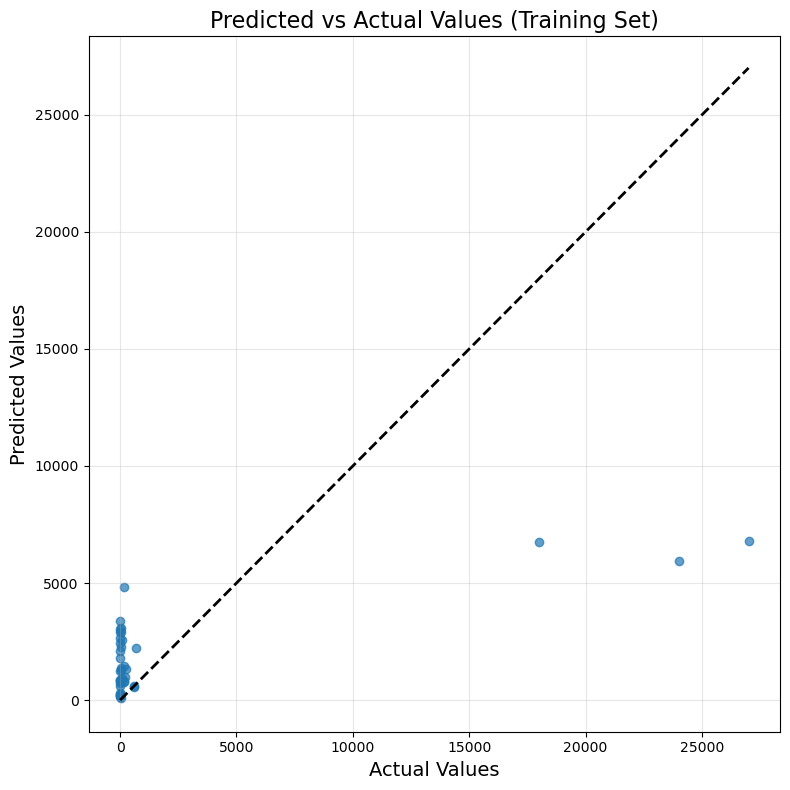

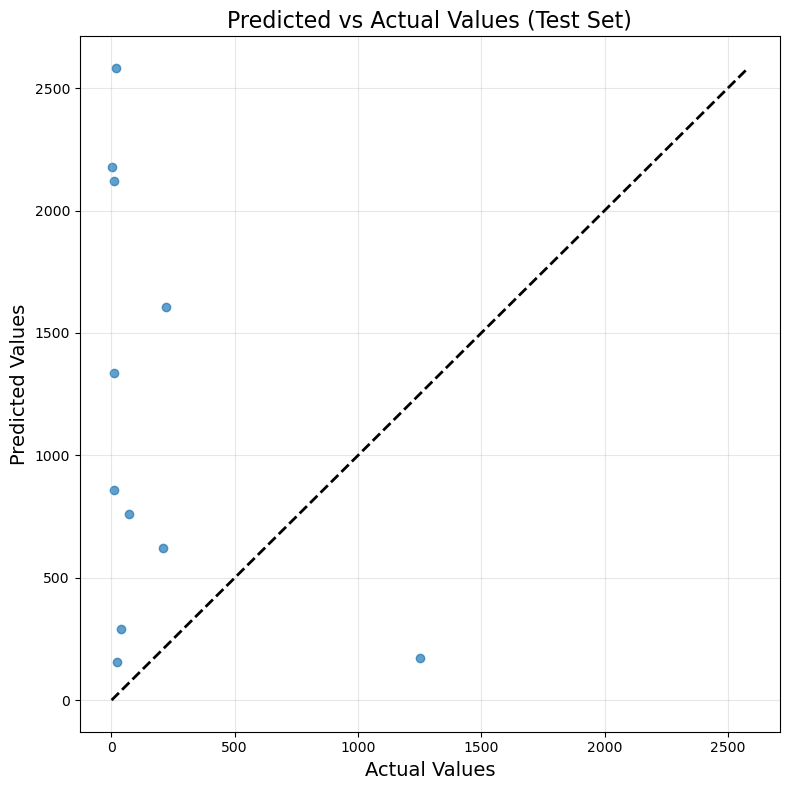

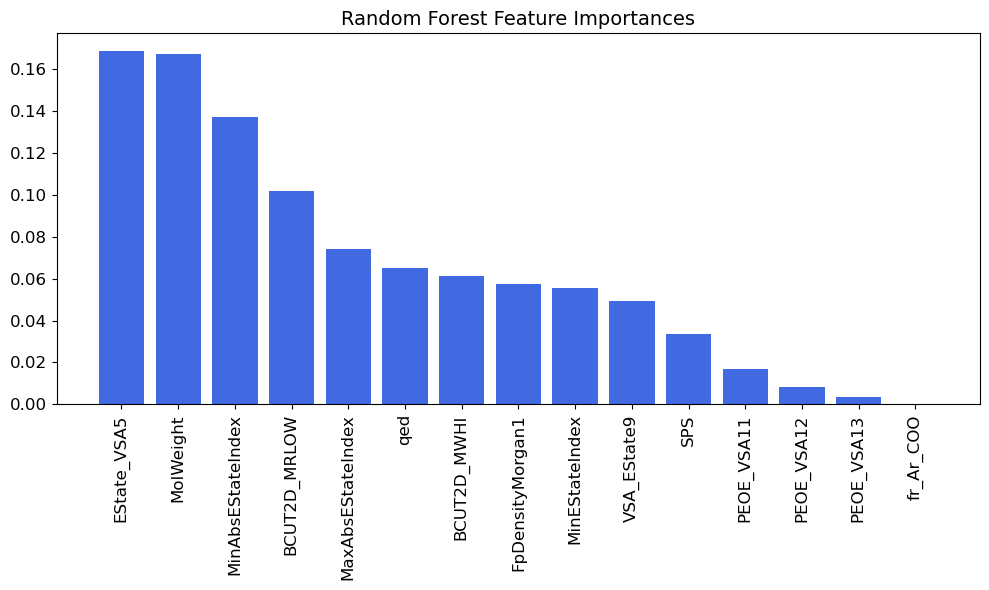


Performing 5-fold cross-validation:

Evaluation on Fold 1 Validation:
  MSE:  32332580.6806
  RMSE: 5686.1745
  MAE:  3291.3280
  R²:   0.0707

Evaluation on Fold 2 Validation:
  MSE:  8261215.3481
  RMSE: 2874.2330
  MAE:  2561.9774
  R²:   -3554.7725

Evaluation on Fold 3 Validation:
  MSE:  11051135.1021
  RMSE: 3324.3248
  MAE:  2755.3046
  R²:   -1499.4783

Evaluation on Fold 4 Validation:
  MSE:  71126556.7804
  RMSE: 8433.6562
  MAE:  4173.8596
  R²:   -0.1286

Evaluation on Fold 5 Validation:
  MSE:  76544585.8671
  RMSE: 8748.9763
  MAE:  4155.3744
  R²:   0.0269

Cross-Validation Average Metrics:
  Average MAE:  3387.5688
  Average RMSE: 5813.4729
  Average R²:   -1010.8564

Example prediction for a new molecule:
Predicted Enhancement Factor: 3798.1479


In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import randint, uniform
import matplotlib.pyplot as plt

def load_dataset(file_path):
    """
    Loads the dataset from a CSV file.
    Assumes columns C->Q (indices 2:17) are features (X),
    and column R (index 17) is 'Enhancement Factor' (y).
    """
    df = pd.read_csv(file_path)
    print("\nData Preview:")
    print(df.head(5))  # Show just the first 5 rows

    feature_cols = df.columns[2:17]  # 15 features
    target_col = df.columns[17]      # Enhancement Factor
    X = df[feature_cols].values
    y = df[target_col].values
    return X, y, feature_cols

def remove_correlated_features(X, feature_cols, threshold=0.90):
    """
    Optional step to remove features that have absolute Spearman correlation
    above 'threshold'. Returns pruned X and updated feature_cols.
    """
    df_features = pd.DataFrame(X, columns=feature_cols)
    corr_matrix = df_features.corr(method='spearman').abs()
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

    df_pruned = df_features.drop(columns=to_drop)
    print(f"\nRemoved {len(to_drop)} highly correlated features (threshold={threshold}).")
    print("Dropped features:", to_drop)
    return df_pruned.values, df_pruned.columns.tolist()

def evaluate_model(model, X, y, description="All Data"):
    """
    Prints MSE, RMSE, MAE, R² for the model on (X, y).
    Returns a dictionary with all metrics.
    """
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, preds)
    r2 = r2_score(y, preds)

    print(f"\nEvaluation on {description}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R²:   {r2:.4f}")
    
    return {"mse": mse, "rmse": rmse, "mae": mae, "r2": r2}

def plot_feature_importances(model, feature_cols, max_features=None):
    """
    Plots feature importances for the trained RandomForestRegressor.
    If max_features is specified, only the top N features are shown.
    """
    importances = model.feature_importances_
    # Pair each importance with its feature name
    feat_imp_pairs = list(zip(feature_cols, importances))
    # Sort descending by importance
    feat_imp_pairs.sort(key=lambda x: x[1], reverse=True)

    if max_features is not None:
        feat_imp_pairs = feat_imp_pairs[:max_features]

    labels, scores = zip(*feat_imp_pairs)

    plt.figure(figsize=(10, 6))
    plt.bar(range(len(scores)), scores, color="royalblue")
    plt.xticks(range(len(scores)), labels, rotation=90, fontsize=12)
    plt.yticks(fontsize=12)
    plt.title("Random Forest Feature Importances", fontsize=14)
    plt.tight_layout()
    plt.show()

def plot_prediction_vs_actual(y_true, y_pred, set_name="Test Set"):
    """
    Create a scatter plot of predicted vs actual values with a perfect prediction line
    """
    plt.figure(figsize=(8, 8))
    plt.scatter(y_true, y_pred, alpha=0.7)
    
    # Add perfect prediction line
    min_val = min(min(y_true), min(y_pred))
    max_val = max(max(y_true), max(y_pred))
    plt.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2)
    
    plt.xlabel('Actual Values', fontsize=14)
    plt.ylabel('Predicted Values', fontsize=14)
    plt.title(f'Predicted vs Actual Values ({set_name})', fontsize=16)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def cross_validate_model(X, y, best_params, cv=5):
    """
    Perform k-fold cross-validation with the best parameters
    and report metrics for each fold.
    """
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)
    fold_metrics = []
    
    print(f"\nPerforming {cv}-fold cross-validation:")
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_fold_train, X_fold_val = X[train_idx], X[val_idx]
        y_fold_train, y_fold_val = y[train_idx], y[val_idx]
        
        # Create and train model with best parameters
        model = RandomForestRegressor(**best_params, random_state=42)
        model.fit(X_fold_train, y_fold_train)
        
        # Evaluate on validation set
        metrics = evaluate_model(model, X_fold_val, y_fold_val, f"Fold {fold+1} Validation")
        fold_metrics.append(metrics)
    
    # Calculate average metrics across all folds
    avg_mae = np.mean([m['mae'] for m in fold_metrics])
    avg_rmse = np.mean([m['rmse'] for m in fold_metrics])
    avg_r2 = np.mean([m['r2'] for m in fold_metrics])
    
    print("\nCross-Validation Average Metrics:")
    print(f"  Average MAE:  {avg_mae:.4f}")
    print(f"  Average RMSE: {avg_rmse:.4f}")
    print(f"  Average R²:   {avg_r2:.4f}")
    
    return fold_metrics

def main():
    # 1. Load dataset
    file_path = 'C:/Users/gagno/Downloads/molecule_features.csv'  # Replace with your CSV path
    X_raw, y, feature_cols = load_dataset(file_path)
    
    # 2. Train-test split (before any preprocessing to prevent data leakage)
    X_train_raw, X_test_raw, y_train, y_test = train_test_split(
        X_raw, y, test_size=0.2, random_state=42
    )
    print(f"\nSplit dataset: {X_train_raw.shape[0]} training samples, {X_test_raw.shape[0]} test samples")

    # 3. (Optional) Remove highly correlated features - using only training data to decide
    X_train_pruned, pruned_cols = remove_correlated_features(X_train_raw, feature_cols, threshold=0.90)
    
    # Apply the same feature pruning to the test set
    test_df = pd.DataFrame(X_test_raw, columns=feature_cols)
    X_test_pruned = test_df[pruned_cols].values

    # 4. Scale features - fit only on training data to prevent data leakage
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train_pruned)
    # Apply the same scaling to test data
    X_test_scaled = scaler.transform(X_test_pruned)

    # 5. Define param distributions for RandomizedSearchCV
    param_distributions = {
        'n_estimators': randint(50, 300),
        'max_depth': randint(2, 15),
        'min_samples_leaf': randint(1, 5),
        'max_features': uniform(0.3, 0.6)
    }

    # 6. K-fold cross-validation - only on training data
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # 7. Initialize base RandomForestRegressor
    rf_base = RandomForestRegressor(random_state=42)

    # 8. RandomizedSearchCV for hyperparameter tuning
    random_search = RandomizedSearchCV(
        estimator=rf_base,
        param_distributions=param_distributions,
        n_iter=30,
        scoring='r2',
        cv=kfold,
        random_state=42,
        n_jobs=-1,
        refit=True,
        verbose=1
    )

    # 9. Fit the search on the training data only
    random_search.fit(X_train_scaled, y_train)

    print("\nBest Hyperparameters found:")
    print(random_search.best_params_)
    print(f"Best R² from CV: {random_search.best_score_:.4f}")

    # 10. Retrieve best model
    best_model = random_search.best_estimator_

    # 11. Evaluate best model on both training and test sets
    train_metrics = evaluate_model(best_model, X_train_scaled, y_train, "Training Data")
    test_metrics = evaluate_model(best_model, X_test_scaled, y_test, "Test Data")
    
    # 12. Calculate and print the difference between training and test metrics
    print("\nTraining vs Test Performance Difference:")
    print(f"  MAE difference:  {abs(train_metrics['mae'] - test_metrics['mae']):.4f}")
    print(f"  RMSE difference: {abs(train_metrics['rmse'] - test_metrics['rmse']):.4f}")
    print(f"  R² difference:   {abs(train_metrics['r2'] - test_metrics['r2']):.4f}")
    
    # 13. Create visualizations for actual vs predicted values
    train_preds = best_model.predict(X_train_scaled)
    test_preds = best_model.predict(X_test_scaled)
    
    # Visualize predictions vs actual values
    plot_prediction_vs_actual(y_train, train_preds, "Training Set")
    plot_prediction_vs_actual(y_test, test_preds, "Test Set")

    # 14. Plot Feature Importances
    plot_feature_importances(best_model, pruned_cols, max_features=len(pruned_cols))
    
    # 15. Perform k-fold cross-validation with the best parameters
    cv_metrics = cross_validate_model(X_train_scaled, y_train, random_search.best_params_)

    # 16. Example: Predict Enhancement Factor for new data
    if len(feature_cols) != len(pruned_cols):
        print("\nNote: Some features were dropped during correlation analysis.")
        print("When making predictions on new data, use only these features:", pruned_cols)
    
    # Example with a new molecule - adjust features to match pruned_cols
    print("\nExample prediction for a new molecule:")
    new_molecule_features = np.array([[
        1606.29, 0.41483, 0.07137, 0.3726,
        12.8, 1.29, 0.11, 0.23, 5.52, 0.33,
        0.1, 1, 0, 0, 1
    ]], dtype=float)

    # If some features were dropped, remove them from new_molecule_features as well
    new_df = pd.DataFrame(new_molecule_features, columns=feature_cols)
    new_df = new_df[pruned_cols]  # Keep only the pruned columns
    new_molecule_scaled = scaler.transform(new_df.values)

    predicted_value = best_model.predict(new_molecule_scaled)
    print(f"Predicted Enhancement Factor: {predicted_value[0]:.4f}")

if __name__ == "__main__":
    main()